In [21]:
import numpy as np
import scipy as sp
from functools import lru_cache
from matplotlib import pyplot as plt

# Studies in Digital Signal Processing, Project 2

### Initial auxiliary functions

In [22]:
def plot_freq_response(H: np.ndarray, w: np.ndarray, title: str = '') -> None: # Function to plot frequency response for H and w
    H[H == 0] = 10e-10 # Replace values ​​equal to 0 with a non-zero value, but sufficiently small
    # Defining the subplots
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 8), layout='constrained')
    fig.suptitle(title)
    plt.setp(ax[:, :], xlabel='Angular frequency $\omega$')
    plt.setp(ax[:, :], title='Frequency Response of $H(e^{j\omega})$')
    # Magnitude
    H_abs = abs(H)
    ax[0, 0].plot(w, H_abs)
    plt.setp(ax[0, 0], ylabel='Magnitude')
    # Phase in degrees
    H_phase_deg = np.angle(H, deg=True)
    ax[0, 1].plot(w, H_phase_deg)
    plt.setp(ax[0, 1], ylabel='Phase (Degrees)')
    # Magnitude in dB
    H_mag_db = 10 * np.log10(abs(H))
    ax[1, 0].plot(w, H_mag_db)
    plt.setp(ax[1, 0], ylabel='Magnitude (dB)')
    # Phase in rad
    H_phase = np.angle(H)
    ax[1, 1].plot(w, H_phase)
    plt.setp(ax[1, 1], ylabel='Phase (Radians)')
    # Show result
    plt.show()


## Section 1

An electrocardiogram data acquisition system was mistakenly connected too close to the power grid. As a result, power grid interference (at 60 Hz) appears prominently in the acquired signal. Our goal is to design a digital filter to completely eliminate noise at 60 Hz. The sampling frequency of the system is:

$$ f_a = 500~Hz $$

### Section 1-A

Let's start by designing the filter in question using the placement of poles and zeros in the z-plane. We will draw the poles and zeros diagram of the designed filter, indicating which poles and zeros were indicated and why these poles/zeros were chosen.

Knowing that $f_a = 500 \ Hz$, and that the noise is located at $60 \ Hz$, we have:

$500 \rightarrow 2\pi$

$60 \ \ \rightarrow \Omega$

Therefore, the transfer function of our notch filter will have zeros at $e^{0.24j\pi}$ and at $e^{-0.24j\pi}$ and poles at $r e^{0.24j\pi}$ and at $r e^{-0.24j\pi}$, eventually we will adopt $r = 0.9$, with the following pole diagram:

<img src="diag1.png" alt="drawing" width="400"/>

Where $O$ represents a zero and $X$ represents a pole.





### Section 1-B

From the diagram developed in the previous question, we will write the filter transfer function H(z) and the difference equation of the system that realizes the filter.

The transfer function is given by:

$H(z) = \frac{(z - e^{0.24j\pi})(z - e^{-0.24j\pi})}{(z - 0.9e^{0.24j\pi})(z - 0.9e^{-0.24j\pi})}$

$H(z) = \frac{z^2 - z (e^{0.24j\pi} + e^{-0.24j\pi}) + 1}{z^2 - 0.9 z (e^{0.24j\pi} + e^{-0.24j\pi}) + 0.9^2}$

$H(z) = \frac{z^2 - 2 z \cos(0.24 \pi) + 1}{z^2 - 1.8 z \cos(0.24 \pi) + 0.9^2}$

And from this we can build the difference equation:

$H(z) = \frac{1 - 2 z^{-1} \cos(0.24 \pi) + z^{-2}}{1 - 1.8 z^{-1} \cos(0.24 \pi) + 0.9^2z^{-2}}$

$\frac{Y(z)}{X(z)} = H(z)$

$(1 - 1.8 z^{-1} \cos(0.24 \pi) + 0.9^2z^{-2})Y(z) = (1 - 2 z^{-1} \cos(0.24 \pi) + z^{-2})X(z)$

$y[n] - 1.8 \cos(0.24 \pi) y[n-1] + 0.9^2y[n-2] = x[n] - 2 \cos(0.24 \pi) x[n-1] + x[n-2]$

### Section 1-C

In this section, we will plot the **frequency response** of the designed filter (magnitude and phase).

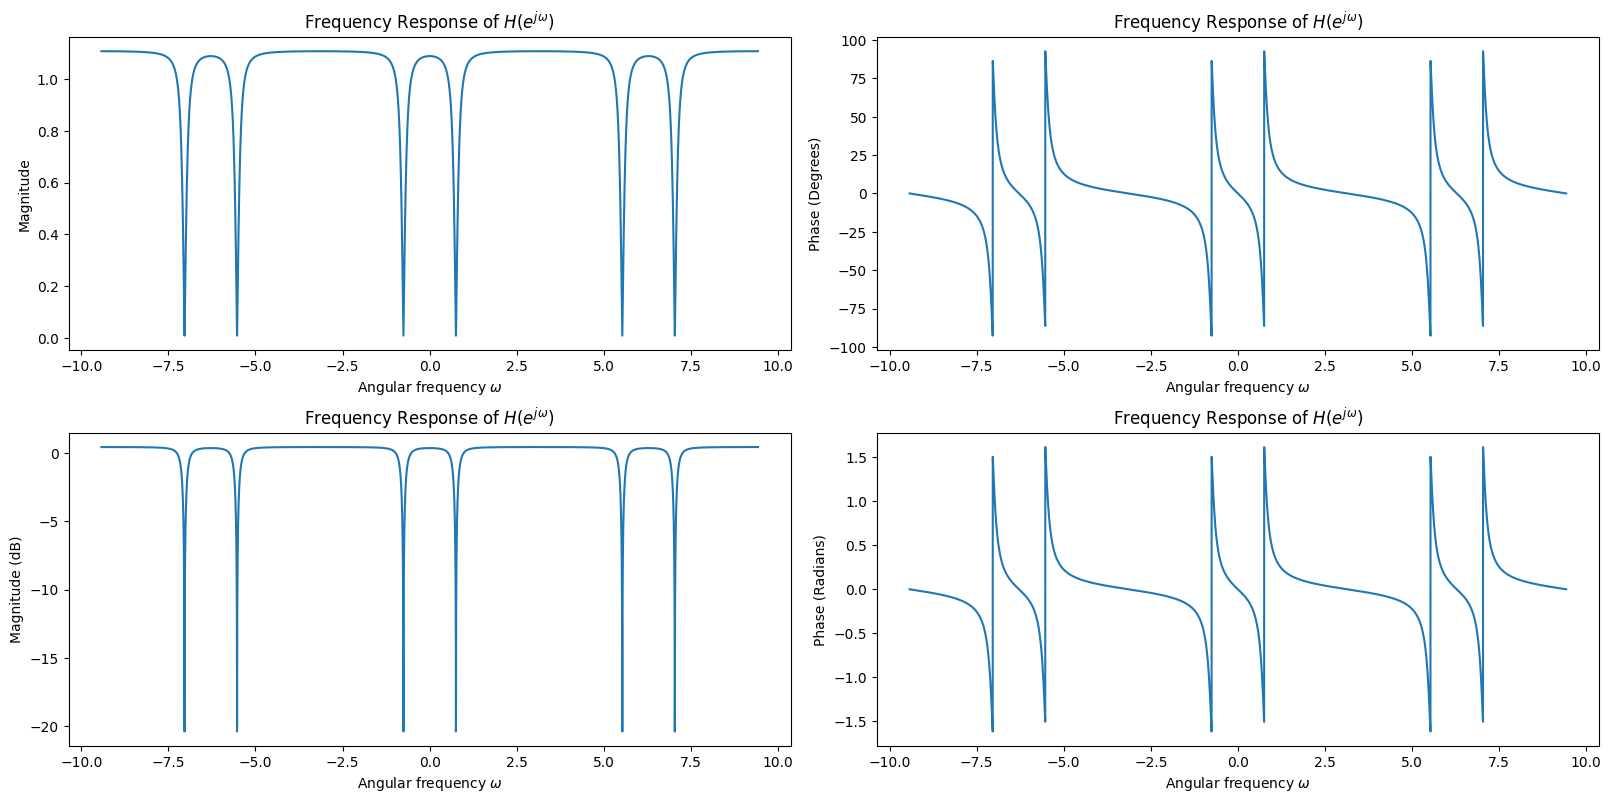

In [23]:
b0, b1, b2 = 1, -2 * np.cos(0.24 * np.pi), 1
a0, a1, a2 = 1, -1.8 * np.cos(0.24 * np.pi), 0.9**2

w = np.linspace(-3 * np.pi, 3 * np.pi, 10000)
w_axis = np.exp(1j * w)
H = (b0 * w_axis**2 + b1 * w_axis + b2) / (a0 * w_axis**2 + a1 * w_axis + a2)

plot_freq_response(H, w)

### Section 1-D

In this section, we will load the ECG signal "noisy_ecg_data.mat" and apply the designed filter to this signal. then plot the signal before filtering (x[n]) and the signal after filtering (y[n]).

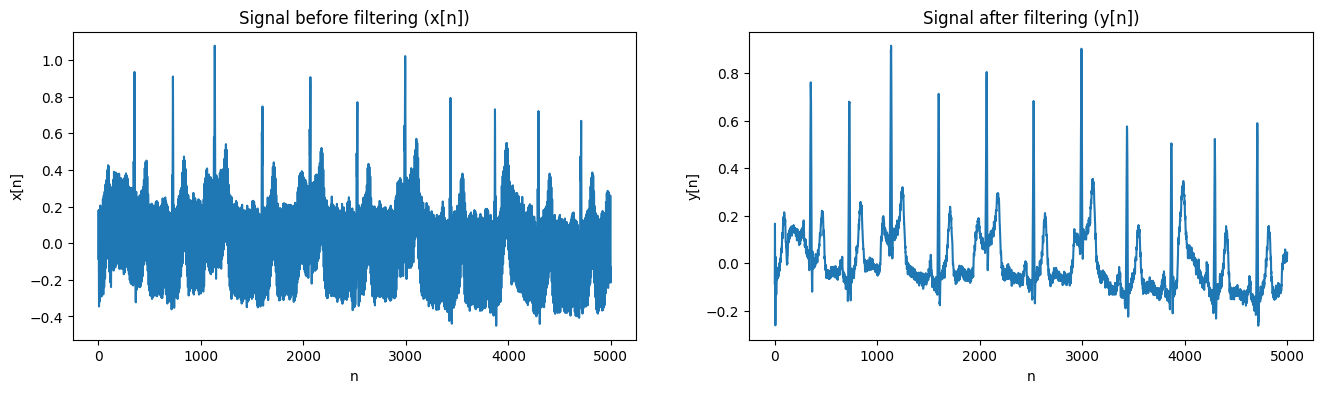

In [24]:
sinal = sp.io.loadmat('noisy_ecg_data.mat')['noisy_ecg'].ravel()
COS_CONSTANT = np.cos(np.pi * 0.24)


def x(n: int) -> float:
    if n < 0:
        return 0
    return sinal[n]


@lru_cache(maxsize=len(sinal))
def y(n: int) -> float:
    if n < 0:
        return 0
    return 1.8*COS_CONSTANT*y(n-1) - (0.9**2)*y(n-2) + x(n) - 2*COS_CONSTANT*x(n-1) + x(n-2)


_, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
plt.setp(ax[:], xlabel='n')
ax[0].plot(range(len(sinal)), sinal)
ax[0].set_title('Signal before filtering (x[n])')
plt.setp(ax[0], ylabel='x[n]')
y_n_filtered = [y(i) for i in range(len(sinal))]
ax[1].plot(range(len(sinal)), y_n_filtered)
ax[1].set_title('Signal after filtering (y[n])')
plt.setp(ax[1], ylabel='y[n]')
plt.show()

## Section 2

Still in the electrocardiogram data acquisition system, it was later found that, even after solving the problem of power line interference (i.e., the signal does not have a specific noise at 60 Hz), the acquired signal had a lot of high frequency noise (above 35 Hz). The objective of this section is to design a digital filter to attenuate frequencies above 35 Hz. The sampling frequency of the system is:

$$ f_a = 500~Hz $$

### Section 2-A

In this section, we will design the filter in question using the placement of poles and zeros in the z-plane, drawing the pole and zero diagram of the designed filter, indicating which poles and zeros were indicated and why these poles/zeros were chosen.

We must build a low-pass filter with a cutoff at $35 Hz$. To do this, we must place two zeros located at $-1$, and position our poles according to the position equivalent to our cutoff frequency:

$500 \rightarrow 2\pi$

$35 \ \ \rightarrow \Omega$

Therefore, $\Omega = 0.14\pi$, which means that our transfer function will have its poles at $re^{\pm j0.14\pi}$. The pole-zero diagram will therefore be:

<img src="diag2.png" alt="drawing" width="400"/>

Where $X$ represents a pole, and $O$ represents a zero.

### Section 2-B

From the diagram developed in the previous question, we will now write the filter transfer function H(z) and the difference equation of the system that realizes the filter.

The transfer function is given by:

$H(z) = \frac{(z + 1)^2}{(z - 0.9e^{j0.14\pi})(z - 0.9e^{-j0.14\pi})}$

$H(z) = \frac{ z^2 + 2z + 1 }{ z^2 - z (0.9e^{j0.14\pi} + 0.9e^{-j0.14\pi}) 0.81}$

$H(z) = \frac{ z^2 + 2z + 1 }{ z^2 - 1.8 z \cos(0.14\pi) + 0.81}$

And from this we can build the difference equation:

$H(z) = \frac{ 1 + 2z^{-1} + z^{-2} }{ 1 - 1.8z^{-1}\cos(0.14\pi) + 0.81z^{-2} }$

$\frac{Y(z)}{X(z)} = H(z)$

$(1 - 1.8z^{-1}\cos(0.14\pi) + 0.81z^{-2})Y(z) = (1 + 2z^{-1} + z^{-2})X(z)$

$y[n] - 1.8\cos(0.14\pi)y[n-1] + 0.81y[n-2] = x[n] + 2x[n-1] + x[n-2]$

### Section 2-C

In this section, we will plot the **frequency response** of the designed filter (magnitude and phase).

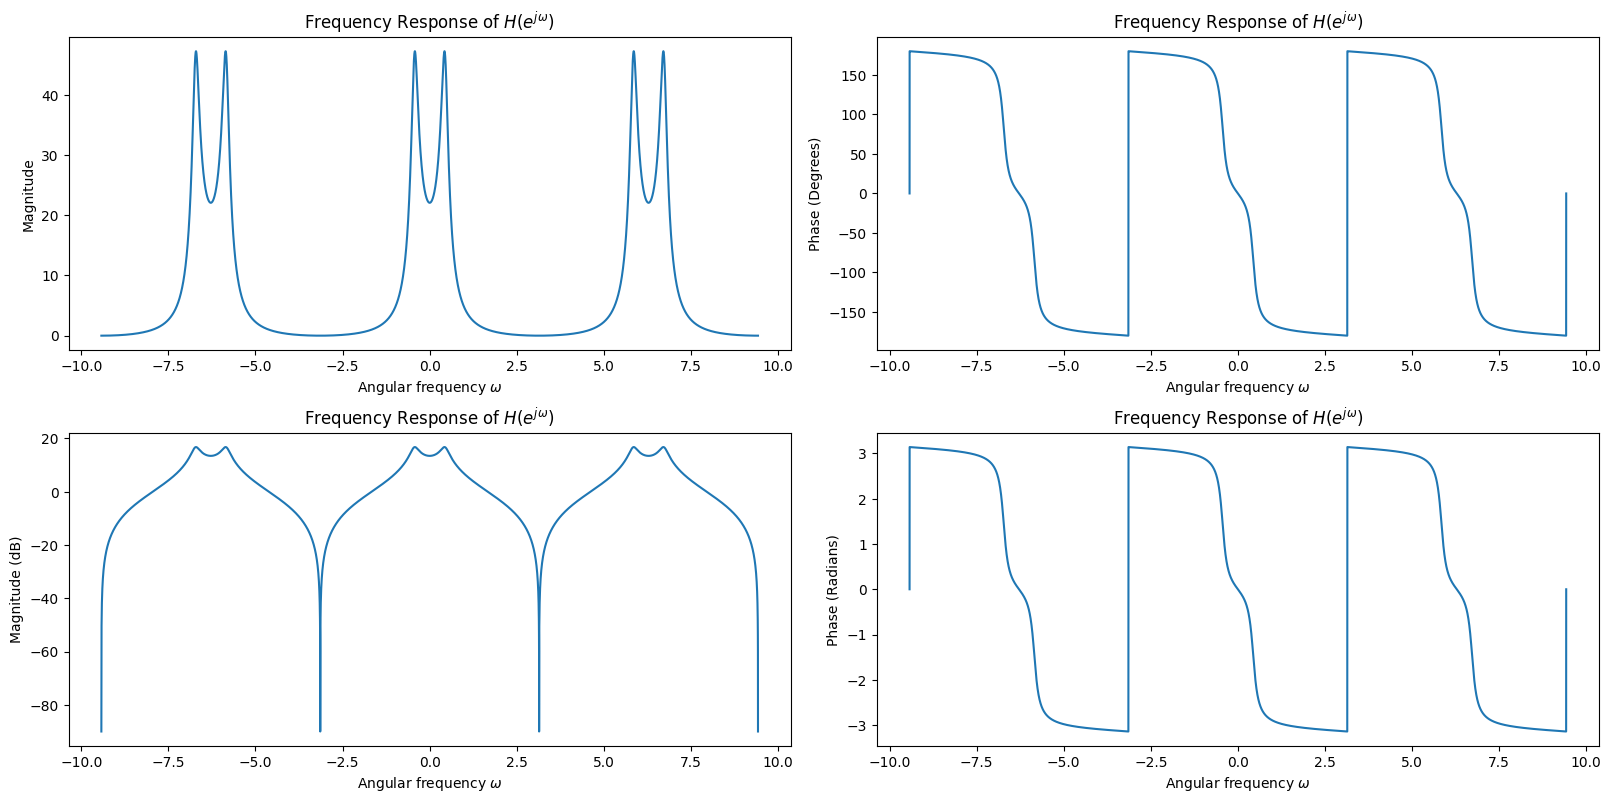

In [25]:
b0, b1, b2 = 1, 2, 1
a0, a1, a2 = 1, -1.8 * np.cos(0.14 * np.pi), 0.81

w = np.linspace(-3 * np.pi, 3 * np.pi, 10000)
w_axis = np.exp(1j * w)
H = (b0 * w_axis**2 + b1 * w_axis + b2) / (a0 * w_axis**2 + a1 * w_axis + a2)
plot_freq_response(H, w)

### Section 2-D

Let's load the ECG signal "noisy_ecg_data_2.mat" and apply the designed filter to this signal, then plot the signal before filtering (x[n]) and the signal after filtering (y[n]).

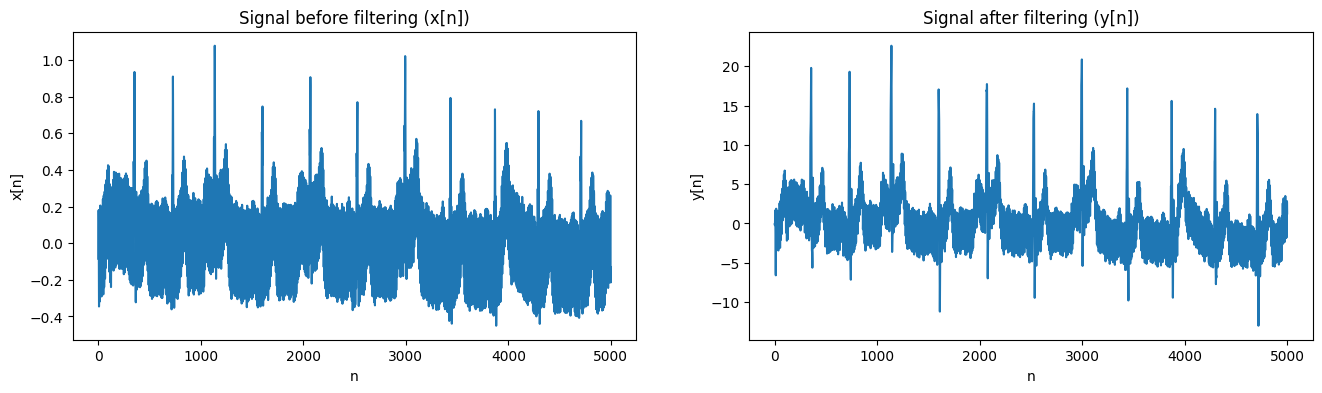

In [26]:
sinal = sp.io.loadmat('noisy_ecg_data.mat')['noisy_ecg'].ravel()
COS_CONSTANT = np.cos(np.pi * 0.14)


def x(n: int) -> float:
    if n < 0:
        return 0
    return sinal[n]


@lru_cache(maxsize=len(sinal))
def y(n: int) -> float:
    if n < 0:
        return 0
    return 1.8*COS_CONSTANT*y(n-1) - (0.9**2)*y(n-2) + x(n) + 2*x(n-1) + x(n-2)


_, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
plt.setp(ax[:], xlabel='n')
ax[0].plot(range(len(sinal)), sinal)
ax[0].set_title('Signal before filtering (x[n])')
plt.setp(ax[0], ylabel='x[n]')
y_n_filtered = [y(i) for i in range(len(sinal))]
ax[1].plot(range(len(sinal)), y_n_filtered)
ax[1].set_title('Signal after filtering (y[n])')
plt.setp(ax[1], ylabel='y[n]')
plt.show()

## Section 3

Consider the analog filter:

$$ H_a \left(s\right) = \frac{\omega_c}{\omega_c + s}$$

And consider the value:

$$\omega_c = 10^3 $$

### Section 3-A

In this section, we will design a digital approximation for this filter with a 10% criterion. Indicate the calculated sampling rate for this approximation (T1) and compare the frequency response of the designed filter H1 with the frequency response of the analog filter Ha, then plot the frequencies up to at least:

$$ \omega = 10^5 \pi $$

Knowing that:

$H(s) = \frac{\omega_c}{s + \omega_c}$

We determine the corresponding $H(z)$ according to pair 5 of Lathi Table 5.3:

$H(z) = \frac{\omega_c T z}{z - e^{-\omega_c T}}$

Next, we will select the value of T by the criterion according to which the gain at $\omega=\pi/T$ falls to $10\%$ of the maximum gain of the filter. Thus, we obtain:

$|H_a(j\omega)| = \frac{\omega_c}{\sqrt{\omega^2 + \omega_c^2}}$

In this case, $|H_a(j\omega)_{max}| = 1$, which occurs at $\omega = 0$. Using the $10\%$ criterion, we have $|H_a(\frac{\pi}{T})| = 0.1$. We will observe that:

$|H_a(j\omega)| \approx \frac{\omega_c}{\omega} \ \ \ \ \omega \gg \omega_c$

Therefore,

$|H_a(\pi/T)| \approx \frac{\omega_c}{\pi/T} = 0.1 \Rightarrow \pi/T = 10\omega_c = 10^4$

Therefore, the $10\%$ criterion results in $T = 10^{-4}\pi$. Substituting $T$ into the equation for $H(z)$ results in:

$H(z) = \frac{0.1\pi z}{z - e^{-0.1\pi}}$

To determine the frequency response of this digital filter, we will write $H(z)$ as:

$H(z) = \frac{0.1\pi}{1 - e^{-0.1\pi}z^{-1}}$

Therefore,

$H(e^{j\omega}) = \frac{0.1\pi}{1 - e^{-0.1\pi}e^{j\omega}}$

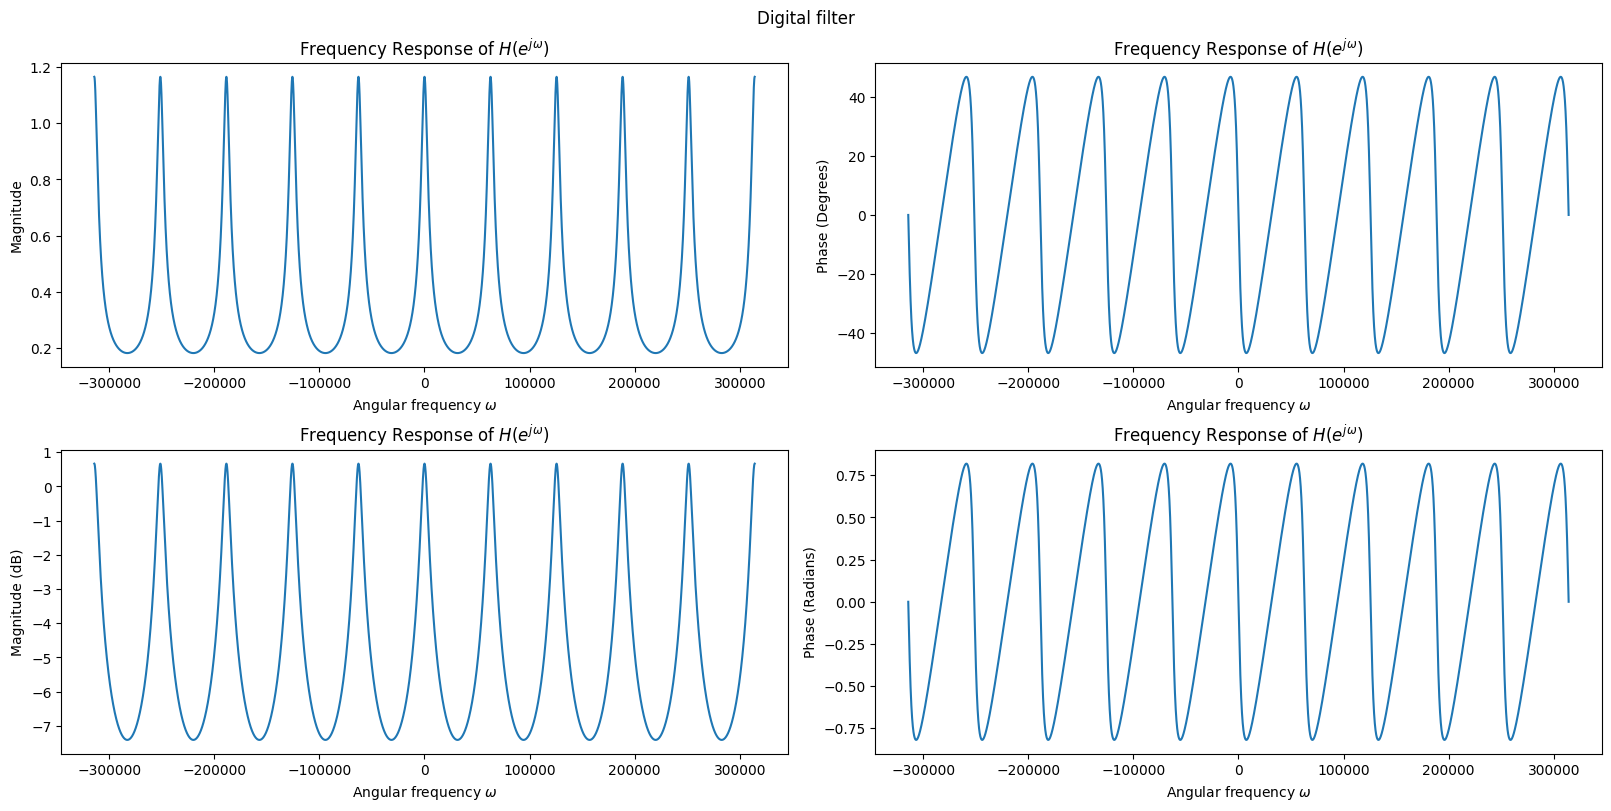

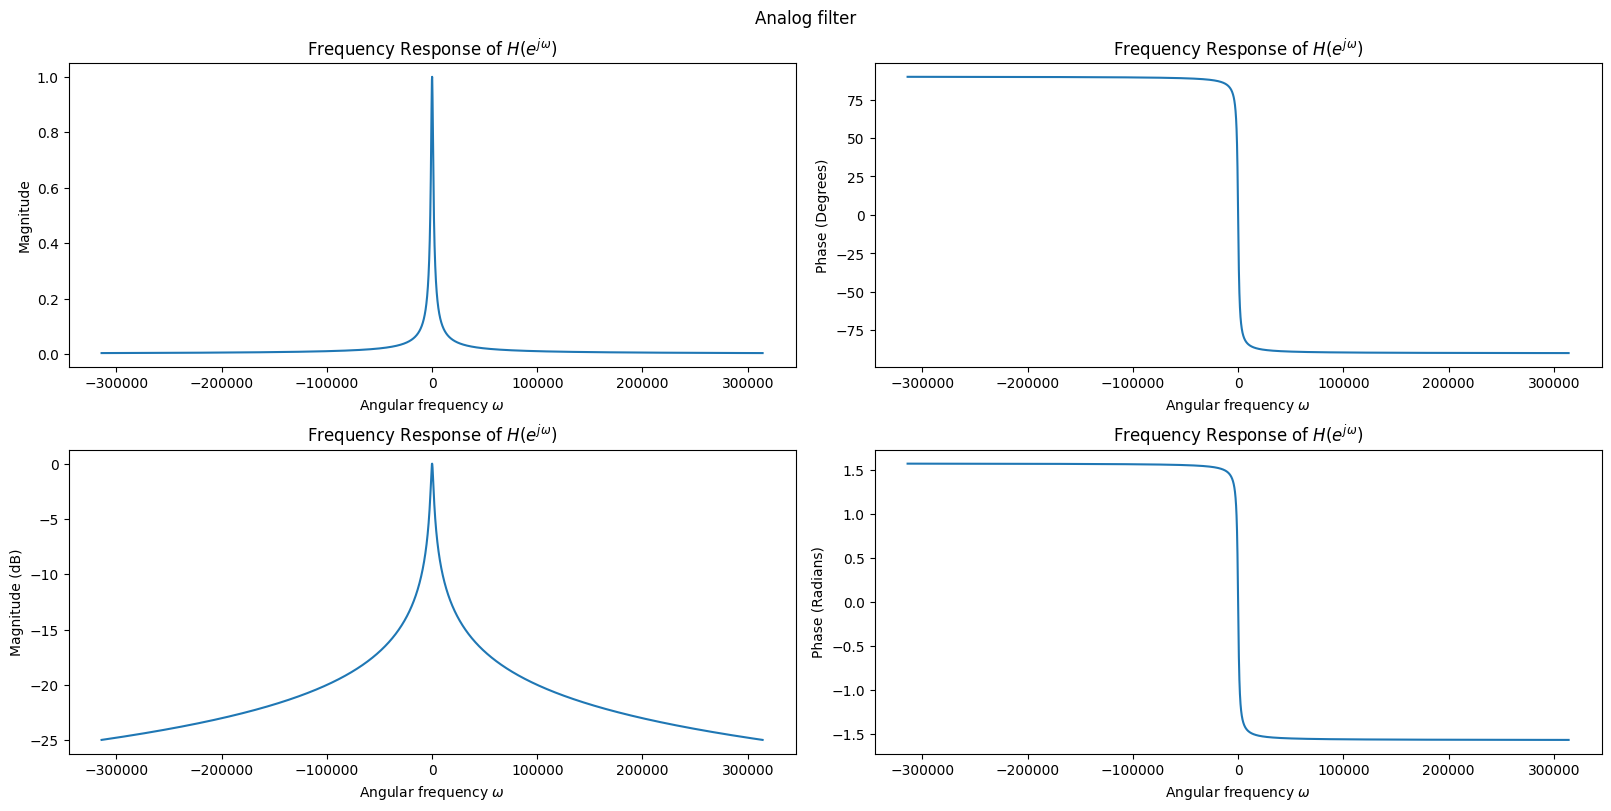

In [27]:
b0, b1 = 0.1 * np.pi, 0
a0, a1 = 1, -np.exp(-0.1 * np.pi)
w = np.linspace(-10**5 * np.pi, 10**5 * np.pi, 10000)
w_axis = np.exp(1j * w)
H = (b0 * w_axis + b1) / (a0 * w_axis + a1)
plot_freq_response(H, w, 'Digital filter')

b = [0, 10**3]
a = [1, 10**3]
H = np.array(sp.signal.freqs(b, a, w))[1]
plot_freq_response(H, w, 'Analog filter')


The $10\%$ criterion yields a frequency response close to that of the analog filter, but still noticeably different.

### Section 3-B

In this section, we will design a digital approximation for this filter with a 1% criterion. Indicate the calculated sampling rate for this approximation (T2) and compare the frequency response of the designed filter H2 with the frequency response of the analog filter Ha, then plot the frequencies up to at least:

$$ \omega = 10^5 \pi $$

Following a reasoning similar to that of the previous section, we have:

$H(z) = \frac{0.01\pi z}{z - e^{-0.01\pi}}$, com $T = 10^{-5}$

and, furthermore,

$H(z) = \frac{0.01\pi}{1 - e^{-0.01\pi}z^{-1}}$

$H(e^{j\omega T}) = \frac{0.01\pi}{1 - e^{-0.01\pi}e^{j\omega T}}$

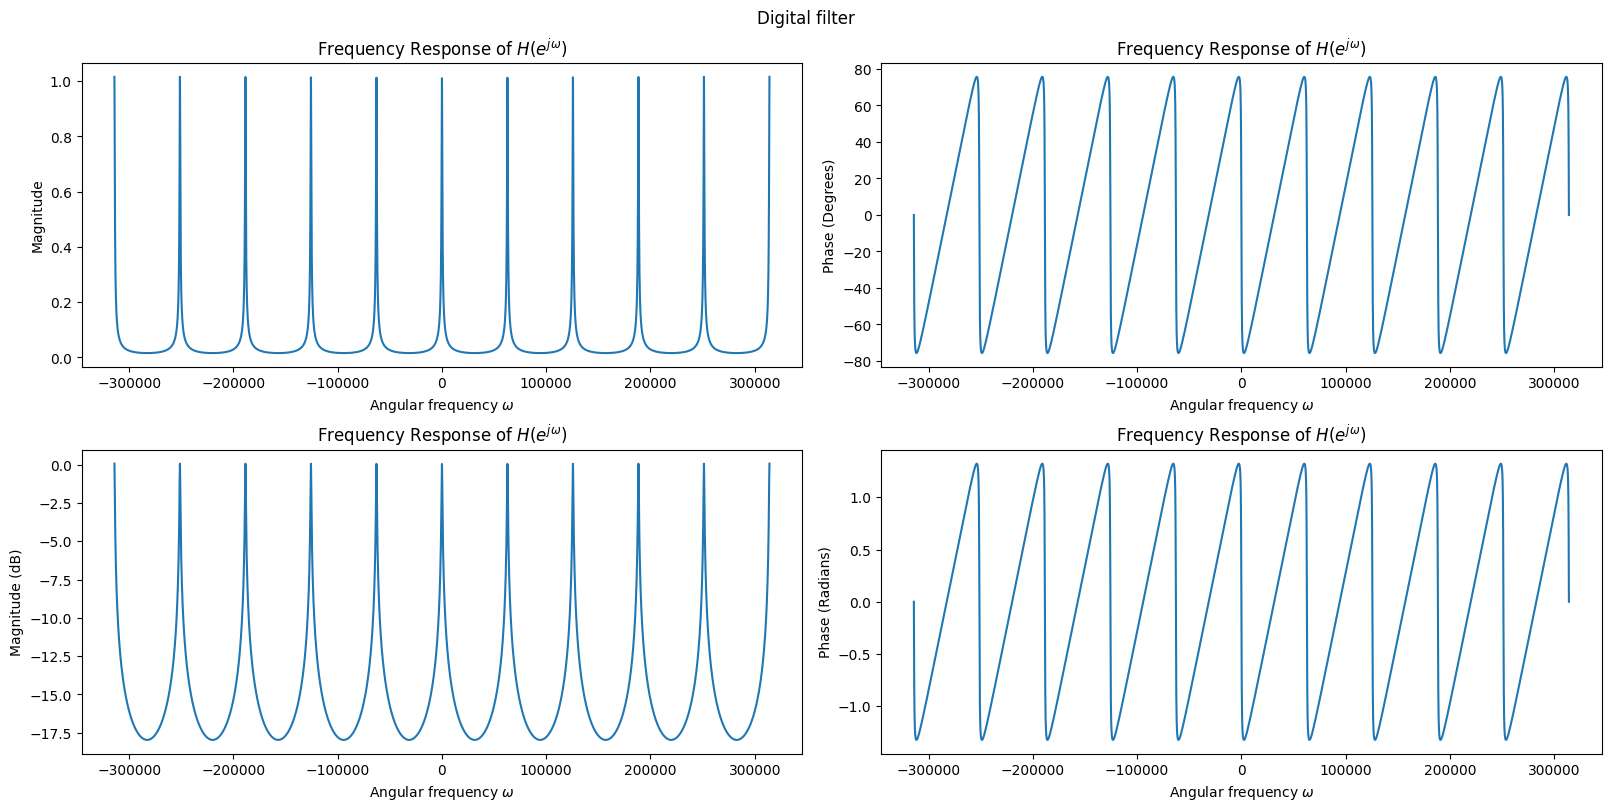

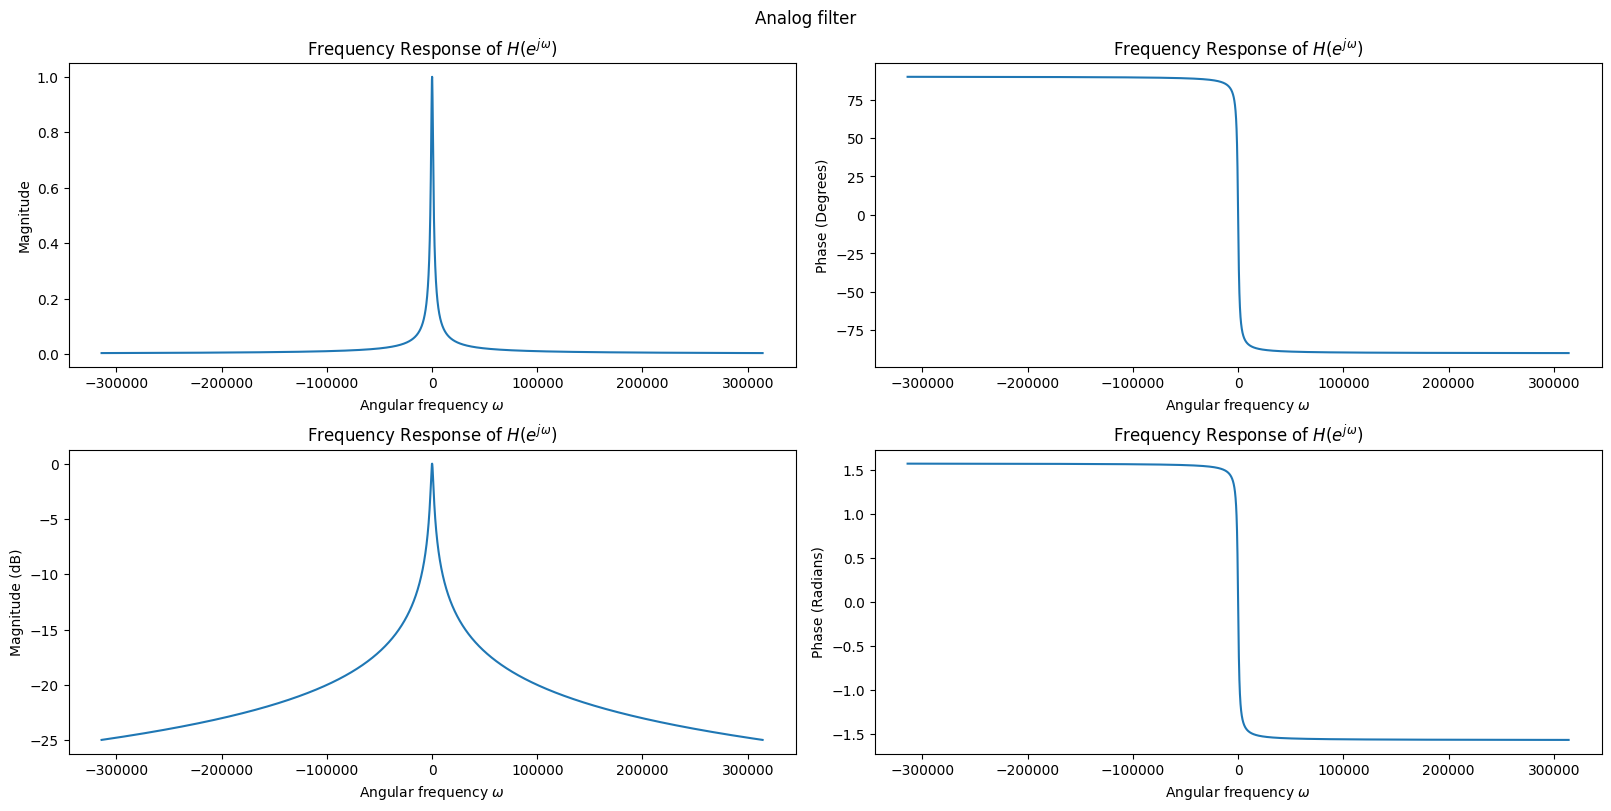

In [28]:
b0, b1 = 0.01 * np.pi, 0
a0, a1 = 1, -np.exp(-0.01 * np.pi)
w = np.linspace(-10**5 * np.pi, 10**5 * np.pi, 10000)
w_axis = np.exp(1j * w)
H = (b0 * w_axis + b1) / (a0 * w_axis + a1)
plot_freq_response(H, w, 'Digital filter')

b = [0, 10**3]
a = [1, 10**3]
H = np.array(sp.signal.freqs(b, a, w))[1]
plot_freq_response(H, w, 'Analog filter')

It is clear, therefore, that the $1\%$ criterion generates a frequency response that is visibly much closer to the frequency response of the analog filter, especially when analyzing the maximum and minimum points of each graph.

### Section 3-C

In this section, we will calculate the impulse response ha(t) of the analog filter Ha(s), as well as the impulse responses h1[n] and h2[n] of the designed filters H1(z) and H2(z), and also **plot** the impulse responses on the same scale.

Knowing that:

$H_a(s) = \frac{10^3}{s - (-10^3)}$

$H_1(z) = \frac{0.1\pi z}{z - e^{-0.1\pi}}$

$H_2(z) = \frac{0.01\pi z}{z - e^{-0.01\pi}}$

And, also:

$\mathcal{Z}^{-1}\{H(s)\} = h(t)$

$\mathcal{Z}^{-1}\{H(z)\} = h[n]$

So, by Lathi Table 5.3:

$h_a(t) = 10^3 e^{-10^3 t}$

$h_1[n] = 0.1\pi e^{-0.1\pi n}$

$h_2[n] = 0.01\pi e^{-0.01\pi n}$


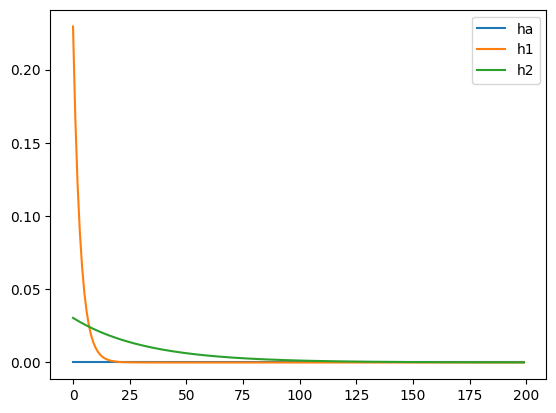

In [29]:
def h_a(t: int) -> float:
    return 10**3 * np.exp(-10**3 * t)


def h_1(n: int) -> float:
    return 0.1 * np.pi * np.exp(-0.1*np.pi*n)


def h_2(n: int) -> float:
    return 0.01 * np.pi * np.exp(-0.01*np.pi*n)


x = np.linspace(1, 200, 200)
ha = h_a(x)
h1 = h_1(x)
h2 = h_2(x)
fig, ax = plt.subplots()
ax.plot(ha, label='ha')
ax.plot(h1, label='h1')
ax.plot(h2, label='h2')
plt.legend()
plt.show()

### Section 3-D

Consider the signal:
$$ x\left(t\right) = e^{- \lambda t} u\left(t\right)$$

with

$$\lambda = 500 $$

In this section, we will calculate the theoretical analog filter response, y(t), as well as the digital filter response H1(z) to the signal sampled at rate T1 (x1[n]) and the digital filter response H2(z) to the signal sampled at rate T2 (x2[n]), and also **plot**, on the same scale, the signal y(t) and the approximations y1[n] and y2[n].

$\mathcal{Z}\{e^{-500t}u(t)\} = X(z) = \frac{z}{z - e^{-500z}}$

Analyzing $X(z)$, we find that $e^{-500z}$ decays very quickly. If $T = 1$, for example, $e^{-500} \approx 0$. Therefore, $X(z) \approx 1 \ \forall \ z > 0$, hence $y(t) \approx h(t)$ and $y[n] \approx h[n]$ for $x(t) = e^{-500t}u(t)$.

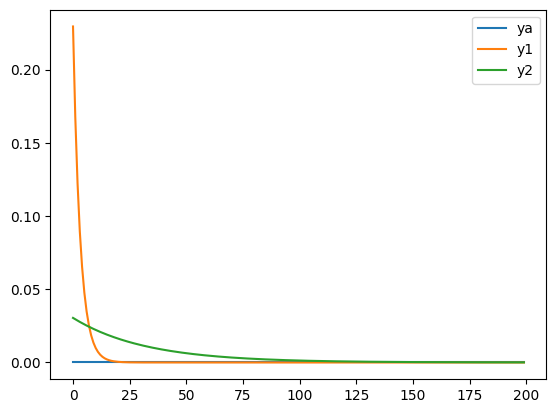

In [30]:
def y_a(t: int) -> float:
    return 10**3 * np.exp(-10**3 * t)


def y_1(n: int) -> float:
    return 0.1 * np.pi * np.exp(-0.1*np.pi*n)


def y_2(n: int) -> float:
    return 0.01 * np.pi * np.exp(-0.01*np.pi*n)


x = np.linspace(1, 200, 200)
ya = y_a(x)
y1 = y_1(x)
y2 = y_2(x)
fig, ax = plt.subplots()
ax.plot(ya, label='ya')
ax.plot(y1, label='y1')
ax.plot(y2, label='y2')
plt.legend()
plt.show()